![](resource/ECG-waves.jpg)

sumber : [link](https://litfl.com/qt-interval-ecg-library/)

original source :
[marianpetruk/ECG_analysis](https://github.com/marianpetruk/ECG_analysis)

In [305]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os 

In [306]:
folder_dataset = "dataset/"
# read dataset, skip first row
ECG = pd.read_csv(os.path.join(folder_dataset, "ECG-01-C1-15-10-2020-14-47(Nicol).csv"), skiprows = [0])

ECG.columns = ['Time', 'ECG']

ECG.head()

Time        ECG
0  2020-10-15 14:47:40.603798  5997808.0
1  2020-10-15 14:47:40.623798  5997512.0
2  2020-10-15 14:47:40.643798  5997724.0
3  2020-10-15 14:47:40.663798  5997623.0
4  2020-10-15 14:47:40.683798  5998005.0

In [307]:
# replace not required char in Time_norm Series 
# ECG["Time_norm"] = ECG.Time.apply(lambda x:  "00:0" + x.replace("[", "") \
#                                                       .replace("]", "") \
#                                                       .replace("'", "") \
#                                                       .replace("'",""))

# create Series with dtype Time
ECG["Idx_Time"] = pd.to_datetime(ECG["Time"]) #, errors='coerce', format="%H:%M:%S.%f")

#Set Time as Index
ECG.index = ECG["Idx_Time"]

# delete unused column 
ECG.drop('Idx_Time', axis=1, inplace=True)
# ECG.drop('Time_norm', axis=1, inplace=True)
ECG.drop('Time', axis=1, inplace=True)

In [308]:
# set sampling rate
fs = 50 #Hz

In [309]:
def plot_signal(data, fs, label="ECG sample raw data"):
    plt.figure(figsize=(20, 5))
    plt.ylabel("Amplitude")

    # Calculate time values in seconds
    times = np.arange(data.shape[0], dtype='float') / fs

    plt.plot(times, data)
    plt.xlabel("Time (s)")
    plt.title(label)
    plt.grid(True)
    plt.show()

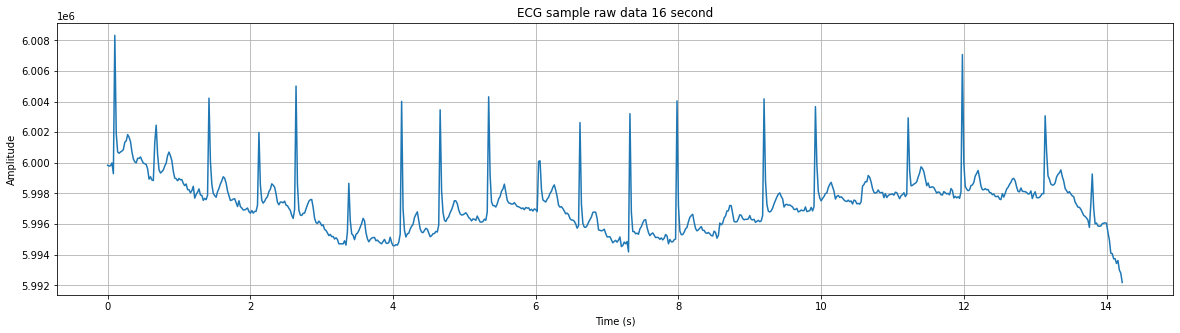

In [310]:
plot_signal(ECG.between_time('14:47:42','14:47:58'), fs, "ECG sample raw data 16 second")

___
___
___
## Baseline Wander Removal
### Asymmetric Least Squares Smoothing

In [311]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from datetime import timedelta

In [312]:
def plot_16s_sample(data, label="Plot 16 s sample"):
    times = np.arange(data.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    plt.title(label)
    plt.grid(True)
    plt.show()

In [316]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

- apply to all sample signal

In [318]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
        
time_interval = [time_result for time_result in perdelta(ECG.index.min(), ECG.index.max(), timedelta(seconds=16))]

In [336]:
ECG_ALS = []
for time_intv in list(zip(time_interval, time_interval[1:])):
    X = ECG.between_time(time_intv[0].time(), time_intv[1].time())
    X_val = X.values[:,0]
    ALS = X_val - baseline_als(X_val)
    ECG_ALS.append(np.array(ALS))

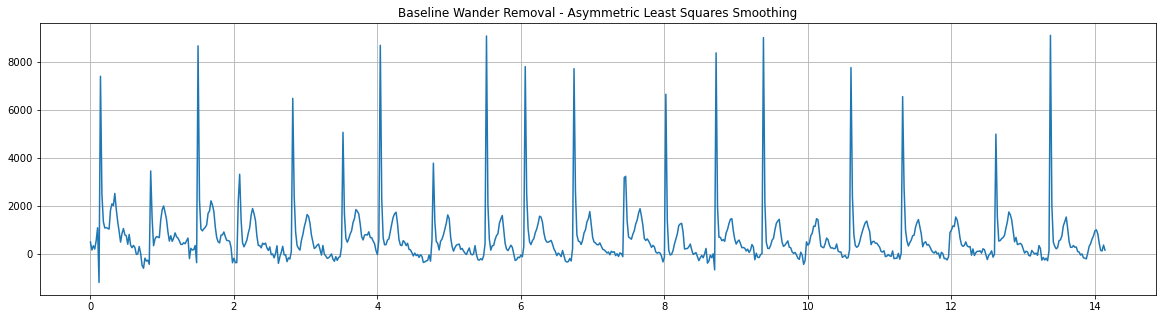

In [337]:
plot_16s_sample(ECG_ALS[0], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing")

## BWR using DWT
`pip install PyWavelets`

In [338]:
import pywt

In [343]:
idx = 4
level = 11

- apply to all signal

In [344]:
coeffs = []
for time_intv in list(zip(time_interval, time_interval[1:])):
    X = ECG.between_time(time_intv[0].time(), time_intv[1].time())
    X_val = X.values[:,0]
    coeff = pywt.wavedec(X_val, 'sym8', mode='sym', level=level)
    coeffs.append(coeff)

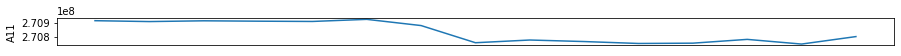

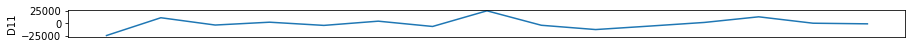

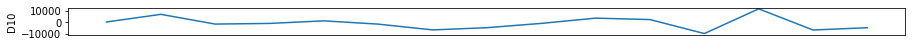

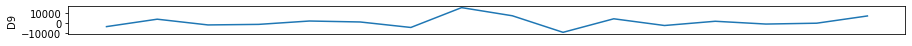

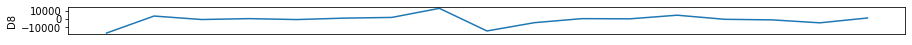

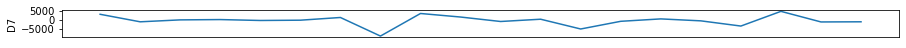

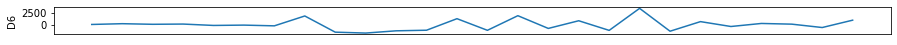

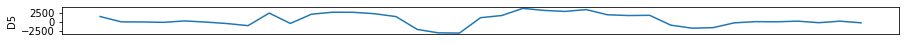

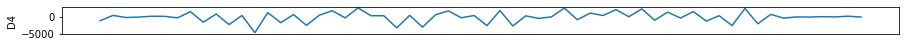

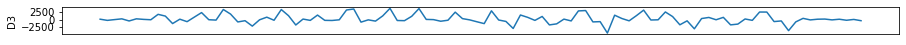

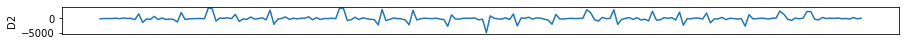

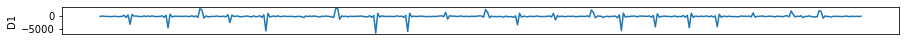

In [346]:
for i, item in enumerate(coeffs[idx]):
    plt.figure(figsize=(15,0.5))
    plt.xticks([])
    n = level + 1 - i
    y_label = "D%d" % n if n <= level else "A%d" % (n - 1)
    plt.ylabel(y_label)
    plt.plot(item)
    plt.show()

In [347]:
ECG_DWT11 = []
for coeff in coeffs:
    for i in range(6):
        coeff[i] = np.zeros_like(coeff[i])
    DWT11 = pywt.waverec(coeff, 'sym8', mode='sym')
    ECG_DWT11.append(DWT11)

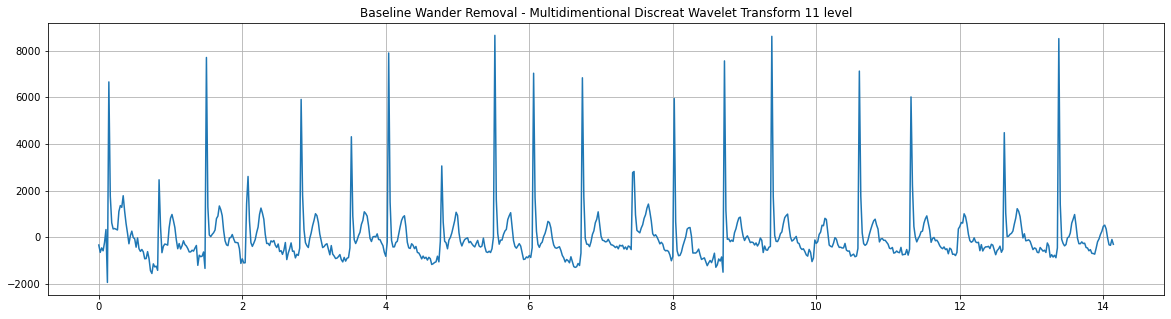

In [348]:
plot_16s_sample(ECG_DWT11[0], label="Baseline Wander Removal - Multidimentional Discreat Wavelet Transform 11 level")

___
___
___
## Signal Normalization

In [349]:
from sklearn.preprocessing import MinMaxScaler

from datetime import timedelta, datetime

In [361]:
scaler = MinMaxScaler()
ECG_Norm = []

for als in ECG_ALS :
    als = np.expand_dims(als, 1)
    scaler = scaler.fit(als)
    
    als_norm = scaler.transform(als) 
    ECG_Norm.append(als_norm)

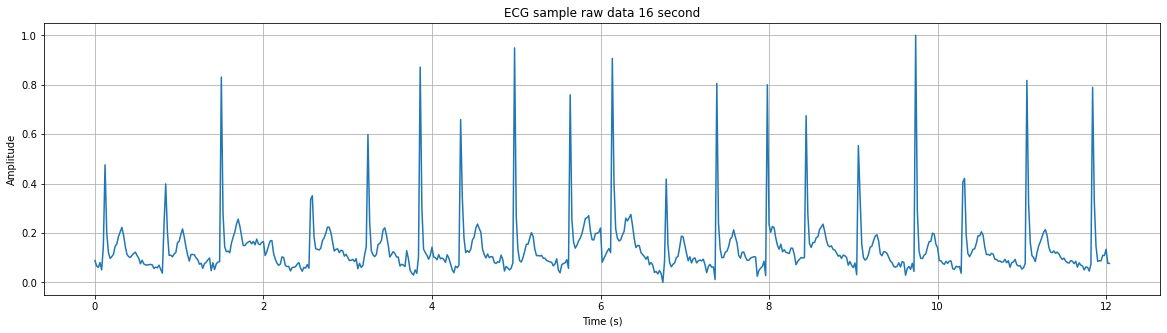

In [364]:
plot_signal(ECG_Norm[3], fs, "ECG sample raw data 16 second")

___
___
___
## QRS Detection

pip package : `pip install py-ecg-detectors`

In [365]:
from ecgdetectors import Detectors

detectors = Detectors(fs)

In [366]:
def plot_r_peaks(r_peaks, data, fs, label = "Detected R peaks"):
    times = np.arange(data.shape[0], dtype='float') / fs

    ymin = np.min(data)
    ymax = np.max(data)
    alpha = 0.2 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    
    plt.vlines([r / fs for r in r_peaks], ymin, ymax,
               color="r",
               linewidth=2)

    plt.title(label)
    plt.grid(True)
    plt.show()

**Christov**

Implementation of Ivaylo I. Christov, “Real time electrocardiogram QRS detection using combined adaptive threshold”, BioMedical Engineering OnLine 2004, vol. 3:28, 2004

In [373]:
help(detectors.christov_detector)

Help on method christov_detector in module ecgdetectors:

christov_detector(unfiltered_ecg) method of ecgdetectors.Detectors instance
    Ivaylo I. Christov, 
    Real time electrocardiogram QRS detection using combined 
    adaptive threshold, BioMedical Engineering OnLine 2004, 
    vol. 3:28, 2004.



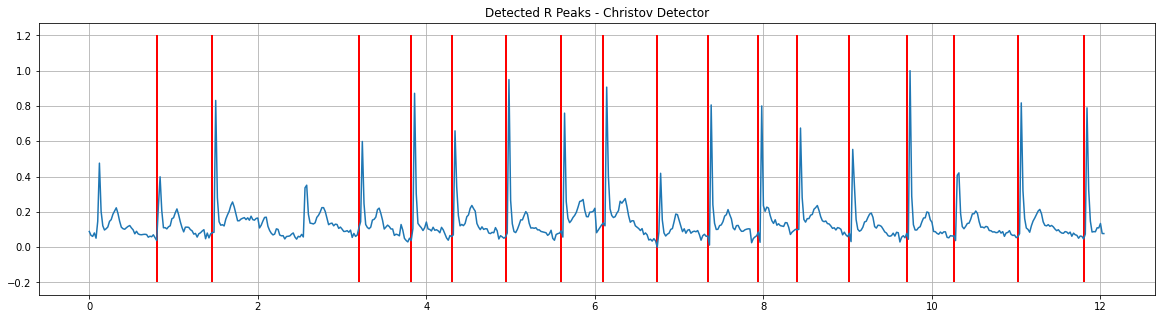

In [367]:
data = np.array(ECG_Norm[3])

r_peaks = detectors.christov_detector(data)

plot_r_peaks(r_peaks, data, fs, label="Detected R Peaks - Christov Detector")

**Engelse and Zeelenberg**

Implementation of W. Engelse and C. Zeelenberg, “A single scan algorithm for QRS detection and feature extraction”, IEEE Comp. in Cardiology, vol. 6, pp. 37-42, 1979 with modifications A. Lourenco, H. Silva, P. Leite, R. Lourenco and A. Fred, “Real Time Electrocardiogram Segmentation for Finger Based ECG Biometrics”, BIOSIGNALS 2012, pp. 49-54, 2012.

In [372]:
help(detectors.engzee_detector)

Help on method engzee_detector in module ecgdetectors:

engzee_detector(unfiltered_ecg) method of ecgdetectors.Detectors instance
    C. Zeelenberg, A single scan algorithm for QRS detection and
    feature extraction, IEEE Comp. in Cardiology, vol. 6,
    pp. 37-42, 1979 with modifications A. Lourenco, H. Silva,
    P. Leite, R. Lourenco and A. Fred, “Real Time
    Electrocardiogram Segmentation for Finger Based ECG
    Biometrics”, BIOSIGNALS 2012, pp. 49-54, 2012.



In [ ]:
data = np.array(ECG_Norm[3])

r_peaks = detectors.engzee_detector(data)

plot_r_peaks(r_peaks, data, fs, label="Detected R Peaks - Engzee Detector")

### RR-intervals (aka NN-intervals)

The term **`NN`** is used in place of **RR** to emphasize the fact that the processed beats are "normal" beats. (с) Wikipedia

Heart rate variability (HRV) is the physiological phenomenon of variation in the time interval between heartbeats. It is measured by the variation in the beat-to-beat interval.

In [383]:
rr = np.diff(r_peaks) / fs * 1000  # in miliseconds

print("rr interval =", rr)

rr interval = [ 660. 1740.  620.  480.  640.  660.  500.  640.  600.  600.  460.  620.
  680.  560.  760.  780.]


### Heartrate variability analysis


In [377]:
from hrv import HRV

hrv = HRV(fs)

r_peaks = np.array(r_peaks)

# calc heart rate
for hr in hrv.HR(r_peaks):
    print("HR : %.2f bpm" % hr)

# print("\nNN20 \n", hrv.NN20(r_peaks))
# print("\nNN50 \n", hrv.NN20(r_peaks))
# print("\nSRMSSD \n", hrv.RMSSD(r_peaks))
# print("\nSDANN \n", hrv.SDANN(r_peaks))
# print("\nSDNN \n", hrv.SDNN(r_peaks))
# print("\nSDSD \n", hrv.SDSD(r_peaks))
# print("\nfAnalysis \n", hrv.fAnalysis(r_peaks))
# print("\npNN20 \n", hrv.pNN20(r_peaks))
# print("\npNN50 \n", hrv.pNN50(r_peaks))

HR : 90.91 bpm
HR : 34.48 bpm
HR : 96.77 bpm
HR : 125.00 bpm
HR : 93.75 bpm
HR : 90.91 bpm
HR : 120.00 bpm
HR : 93.75 bpm
HR : 100.00 bpm
HR : 100.00 bpm
HR : 130.43 bpm
HR : 96.77 bpm
HR : 88.24 bpm
HR : 107.14 bpm
HR : 78.95 bpm
HR : 76.92 bpm


## generate R - R interval for al signal

In [515]:
ECG_split = []
for data in ECG_Norm :
    data = np.array(data)
    r_peaks = detectors.christov_detector(data)
    RRs = np.diff(r_peaks)
    RRs_med = np.median(RRs)
    for rp in r_peaks :
        split = data[:,0][rp : rp + int(RRs_med * 1.2)] 
        pad = np.zeros(94)
        pad[0:len(split)] = split
        ECG_split.append(pad)

In [516]:
def plot_1_sample(data, fs):
    times = np.arange(data.shape[0]) / fs * 1000 

    plt.plot(times, data)
    plt.title("Plot 1 sample")
    plt.xlabel("Time (ms)")
    plt.ylabel("Normalized Value")
    plt.show()

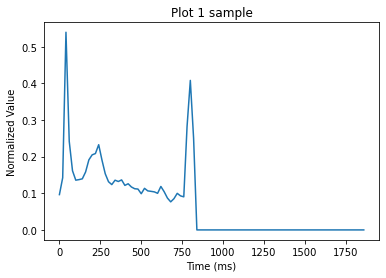

In [517]:
plot_1_sample(ECG_split[100], fs)

___
___
___
## Upsampling Signal

In [557]:
def upsampling_signal(data, fs, new_fs = 125):
    # upsampling interpolation
    result = np.zeros(2*len(data)-1)
    result[0::2] = data
    result[1::2] = (data[1:] + data[:-1]) / 2
    return result

In [558]:
ECG_Split_125 = []
for data in ECG_split :
    data = np.array(data)
    data = upsampling_signal(data, fs) # upsampling signal to 125hz
    ECG_Split_125.append(data)

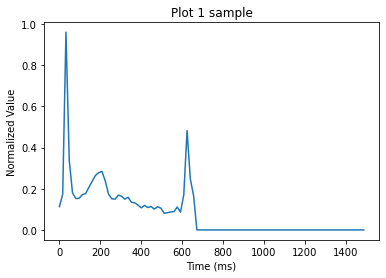

In [566]:
plot_1_sample(ECG_Split_125[4], fs=125)